### Create FEA Keyword Files
This notebook creates the static and dynamic keyword files that will be used to create the structural analysis results for the multi-planar spool subject to slug flow (see Fig. 1 below). Creating keyword files and passing them directly to the analysis engine of the Finite Element (FE) tool allows the user to bypass the GUI. This makes it feasible to run and post-process 50,000 simulations. This notebook also creates the batch files that will contain the commands for running each analysis. The analysis files are distributed across several subfolders (buckets) so that they can be run in parallel using more than one computer.
<p><b>Figure 1: Multi-planar Spool + Slug Loading</b></p>
<img src="mp_spool.png" alt="graphic" style="margin-bottom:20px; width: 350px; float: left;"/>

In [31]:
import os
import itertools
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import ntpath # Equivalent of R's base (remove path)
import glob as gb

# Define the output file path
# Write to Google drive so that files are shared with desktop with Flexcom license
fo_p = '/Volumes/GoogleDrive-117010183998677742603/My Drive/_temp/flex/'

### Method 1: Generate Analysis Cases using Load Case Permutations (Not Used)

In [2]:
# Define load case options
slug_den = {'sd1':500, 'sd2':600, 'sd3':700, 'sd4':800, 'sd5':900} #1
slug_len = {'sl1':10, 'sl2':20, 'sl3':30, 'sl4':40, 'sl5':50} #2
pock_den = {'pd1':100, 'pd2':200, 'pd3':300, 'pd4':400, 'pd5':500} #3
pock_len = {'pl1':10, 'pl2':20, 'pl3':30, 'pl4':40, 'pl5':50} #4
slug_vel = {'sv1':4, 'sv2':6, 'sv3':8, 'sv4':10, 'sv5':12} #5
base_per = {'bp1':6, 'bp2':8, 'bp3':10, 'bp4':12, 'bp5':14} #6
base_amp = {'ba1':100, 'ba2':200, 'ba3':250, 'ba4':300, 'ba5':350} #7

In [3]:
lc = '00001_sd1_sl1_pd1_pl1_sv1_bp1_ba1.keyxm'
lc_slug_den = slug_den.get(lc[6:9])
lc_slug_len = slug_len.get(lc[10:13])
lc_pock_den = pock_den.get(lc[14:17])
lc_pock_len = pock_len.get(lc[18:21])
lc_slug_vel = slug_vel.get(lc[22:25])
lc_base_per = base_per.get(lc[26:29])
lc_base_amp = base_amp.get(lc[30:33])
lc_base_amp

100

In [30]:
# Create load case permutations
c = 1
load_cases = []
print(f'Total cases: {pow(5, 7)}')
for r in itertools.product(list(slug_den.keys()), list(slug_len.keys()), list(pock_den.keys()), list(pock_len.keys()), list(slug_vel.keys()), list(base_per.keys()), list(base_amp.keys())): 
    lc = f'{c:05d}_{r[0]}_{r[1]}_{r[2]}_{r[3]}_{r[4]}_{r[5]}_{r[6]}.keyxm'
    load_cases.append(lc)
    #print(lc)
    c += 1

Total cases: 78125


### Method 2: Generate Analysis Cases using Statistical Distribution (Used)

In [1]:
params = ['slug_den', 'slug_len', 'pock_den', 'pock_len', 'slug_vel', 'base_per', 'base_amp', 'base_pha']

# Define reasonable parameter statistics (based on SLARP Joint Industry Project)
slug_den = {'μ':750, 'σ':75} #1
slug_len = {'μ':10,  'σ':2} #2
pock_den = {'μ':200, 'σ':50} #3
pock_len = {'μ':10,  'σ':2} #4
slug_vel = {'μ':8,   'σ':2} #5
base_per = {'μ':12,  'σ':1} #6
base_amp = {'μ':0.7, 'σ':0.1} #7
base_pha = {'μ':60,  'σ':10} #8

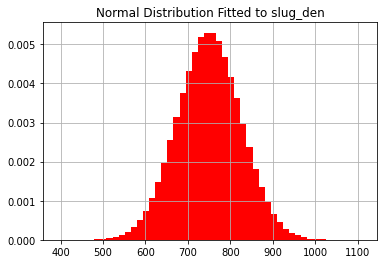

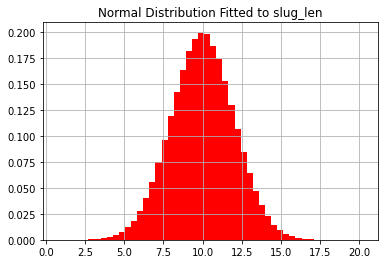

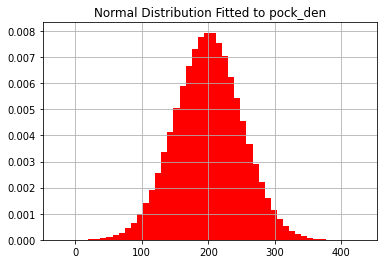

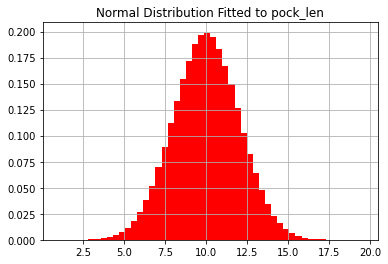

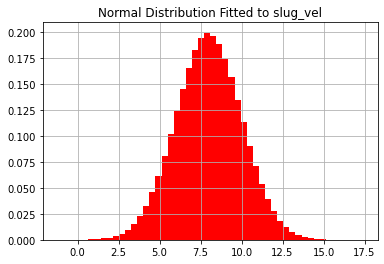

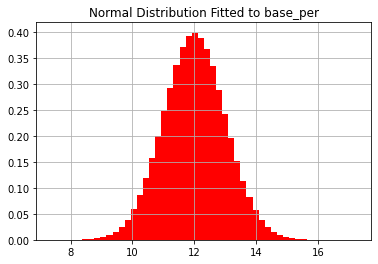

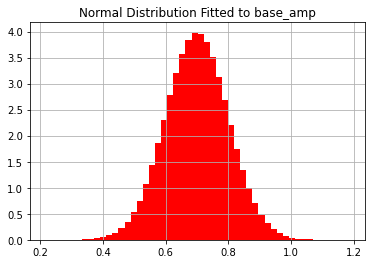

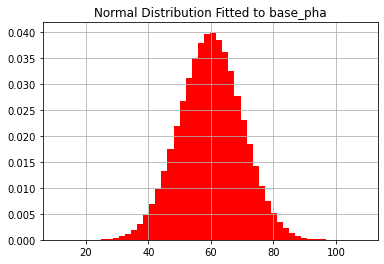

In [6]:
# Define & review a normal distributions for each param
# Need to avoid neagtive values!
for p in params:
    dist_normal = stats.norm(globals()[p].get('μ'), globals()[p].get('σ'))
    globals()[f'ndist_{p}'] = dist_normal
    
    # Verify the created normal distribution
    # rvs: Random Variates
    tdata = pd.DataFrame(dist_normal.rvs(1000000))
    tdata.hist(bins=50, density=True, color='red')
    plt.title(f'Normal Distribution Fitted to {p}')
    plt.grid(True)
    

In [7]:
# Quick check on roundings
round(ndist_slug_vel.rvs(1)[0], 1)

10.2

### Static File Creation
In this section we will create the static analysis 'keyword' file that will be used as an input to the finite element solver Flexcom. Creating keyword files enables the analysis engine of Flexcom to be used to directly perform the analysis and bypass the tool's GUI. This approach makes it feasible to set up and run the planned 50,000 dynamic analysis files. Each dynamic analysis simulation will 'restart' from the same static analysis file created below. The static file defined the structure's geometry, mechanical properties and ither environmental conditions such as water depth, initial fluid density, friction and boundary conditions.

In [8]:
# Define the static file name
fn_s = 'static.keyxm'

In [9]:
# Create the static keyword file
# Use a list to define each row of the keyword file. Each row will then be written to a text file.
# Note: 'C' at the start of a rown denotes a commented out line in the keyword file.
key_file = [
    '$PREPROCESSOR', 
    '*PARAMETERS',
    'C Set Lengths for each straight section of the spool',
    ' L1, 8',
    ' L2, 7',
    ' L3, 10',
    ' L4, 2',
    ' L5, 3',
    ' L6, 10',
    ' L7, 8',
    ' L8, 4',
    ' L9, 10',
    ' TotLen, =[L1+L2+L3+L4+L5+L6+L7+L8+L9+(0.5*PI*R1_2)+(0.5*PI*R2_3)+(0.5*PI*R3_4)+(0.5*PI*R4_5)+(0.5*PI*R5_6)+(0.5*PI*R6_7)+(0.5*PI*R7_8)+(0.5*PI*R8_9)]',
    'C Define Radii for corners at which lines intersect',
    'C Rx_y corresponds to the radius between section x and y',
    ' R1_2, =[3*Do]',
    ' R2_3, =[3*Do]',
    ' R3_4, =[2*Do]',
    ' R4_5, =[2*Do]',
    ' R5_6, =[3*Do]',
    ' R6_7, =[3*Do]',
    ' R7_8, =[3*Do]',
    ' R8_9, =[3*Do]',
    '',
    'C Properties of steel',
    ' E, <207GPa>',
    ' G, <80GPa>',
    ' rho, 7850',
    '',
    'C Diameters',
    ' Do, <400mm>',
    ' WT, <25mm>',
    ' Di, =[Do-2*WT]',
    '',
    'C Hydrodynamic Properties',
    ' Drag, 1.2',
    ' Inertia, 2',
    '',
    'C Ocean Parameters',
    ' WaterDepth, 1500',
    ' rhoWater, 1025',
    ' grav, 9.81',
    '',
    'C Fluid Parameters',
    ' rhoOil, 800',
    ' rhoGas, 200',
    '',
    'C Suggested element lengths',
    ' min_len, =[(0.5*PI*R1_2/10.0)]',
    ' max_len, 0.5',
    '',
    'C Guide Parameters',
    ' Kcont, 1.0E+06',
    ' Length, =[L3*0.1]',
    ' Width,  =[5*Do]',
    ' Thickness, =[1.5*Do]',
    '',
    '$MODEL',
    '*LINES',
    'C Set up straight line sections on the model',
    ' LINE=Line_1',
    ' START=Line_1_Start, =[2*Do], 0, 0',
    ' END=Line_1_End, =[2*Do], =[L1-R1_2], 0',
    ' =[min_len], =[max_len]',
    '',
    ' LINE=Line_2',
    ' START=Line_2_Start, =[2*Do], =[L1], =[-R1_2]',
    ' END=Line_2_End, =[2*Do], =[L1], =[-L2+R2_3]',
    ' =[min_len], =[max_len]',
    '',
    ' LINE=Line_3',
    ' START=Line_3_Start, =[2*Do], =[L1+R2_3], =[-L2]',
    ' END=Line_3_End, =[2*Do], =[L1+L3-R3_4], =[-L2]',
    ' =[min_len], =[max_len]',
    '',
    ' LINE=Line_4',
    ' START=Line_4_Start, =[2*Do+R3_4], =[L1+L3], =[-L2]',
    ' END=Line_4_End, =[2*Do+L4-R4_5], =[L1+L3], =[-L2]',
    ' =[min_len], =[max_len]',
    '',
    ' LINE=Line_5',
    ' START=Line_5_Start, =[2*Do+L4], =[L1+L3], =[-L2+R4_5]',
    ' END=Line_5_End, =[2*Do+L4], =[L1+L3], =[-L2+L5-R5_6]',
    ' =[min_len], =[max_len]',
    '',
    ' LINE=Line_6',
    ' START=Line_6_Start, =[2*Do+L4], =[L1+L3+R5_6], =[-L2+L5]',
    ' END=Line_6_End, =[2*Do+L4], =[L1+L3+L6-R6_7], =[-L2+L5]',
    ' =[min_len], =[max_len]',
    '',
    ' LINE=Line_7',
    ' START=Line_7_Start, =[2*Do+L4], =[L1+L3+L6], =[-L2+L5-R6_7]',
    ' END=Line_7_End, =[2*Do+L4], =[L1+L3+L6], =[-L2+L5-L7+R7_8]',
    ' =[min_len], =[max_len]',
    '',
    ' LINE=Line_8',
    ' START=Line_8_Start, =[2*Do+L4+R7_8], =[L1+L3+L6], =[-L2+L5-L7]',
    ' END=Line_8_End, =[2*Do+L4+L8-R8_9], =[L1+L3+L6], =[-L2+L5-L7]',
    ' =[min_len], =[max_len]',
    '',
    ' LINE=Line_9',
    ' START=Line_9_Start, =[2*Do+L4+L8], =[L1+L3+L6+R8_9], =[-L2+L5-L7]',
    ' END=Line_9_End, =[2*Do+L4+L8], =[L1+L3+L6+L9], =[-L2+L5-L7]',
    ' =[min_len], =[max_len]',
    '',
    '*NODE',
    'C Bend between Sections 1 and 2',
    ' 2, =[2*Do], =[L1-R1_2 + R1_2*cos(radians(90))], =[-R1_2 + R1_2*sin(radians(90))]',
    ' 3, =[2*Do], =[L1-R1_2 + R1_2*cos(radians(80))], =[-R1_2 + R1_2*sin(radians(80))]',
    ' 4, =[2*Do], =[L1-R1_2 + R1_2*cos(radians(70))], =[-R1_2 + R1_2*sin(radians(70))]',
    ' 5, =[2*Do], =[L1-R1_2 + R1_2*cos(radians(60))], =[-R1_2 + R1_2*sin(radians(60))]',
    ' 6, =[2*Do], =[L1-R1_2 + R1_2*cos(radians(50))], =[-R1_2 + R1_2*sin(radians(50))]',
    ' 7, =[2*Do], =[L1-R1_2 + R1_2*cos(radians(40))], =[-R1_2 + R1_2*sin(radians(40))]',
    ' 8, =[2*Do], =[L1-R1_2 + R1_2*cos(radians(30))], =[-R1_2 + R1_2*sin(radians(30))]',
    ' 9, =[2*Do], =[L1-R1_2 + R1_2*cos(radians(20))], =[-R1_2 + R1_2*sin(radians(20))]',
    ' 10, =[2*Do], =[L1-R1_2 + R1_2*cos(radians(10))], =[-R1_2 + R1_2*sin(radians(10))]',
    ' 11, =[2*Do], =[L1-R1_2 + R1_2*cos(radians(00))], =[-R1_2 + R1_2*sin(radians(00))]',
    'C Bend between Sections 2 and 3',
    ' 12, =[2*Do], =[L1+R2_3 + R2_3*cos(radians(180))], =[-L2+R2_3 + R2_3*sin(radians(180))]',
    ' 13, =[2*Do], =[L1+R2_3 + R2_3*cos(radians(190))], =[-L2+R2_3 + R2_3*sin(radians(190))]',
    ' 14, =[2*Do], =[L1+R2_3 + R2_3*cos(radians(200))], =[-L2+R2_3 + R2_3*sin(radians(200))]',
    ' 15, =[2*Do], =[L1+R2_3 + R2_3*cos(radians(210))], =[-L2+R2_3 + R2_3*sin(radians(210))]',
    ' 16, =[2*Do], =[L1+R2_3 + R2_3*cos(radians(220))], =[-L2+R2_3 + R2_3*sin(radians(220))]',
    ' 17, =[2*Do], =[L1+R2_3 + R2_3*cos(radians(230))], =[-L2+R2_3 + R2_3*sin(radians(230))]',
    ' 18, =[2*Do], =[L1+R2_3 + R2_3*cos(radians(240))], =[-L2+R2_3 + R2_3*sin(radians(240))]',
    ' 19, =[2*Do], =[L1+R2_3 + R2_3*cos(radians(250))], =[-L2+R2_3 + R2_3*sin(radians(250))]',
    ' 20, =[2*Do], =[L1+R2_3 + R2_3*cos(radians(260))], =[-L2+R2_3 + R2_3*sin(radians(260))]',
    ' 21, =[2*Do], =[L1+R2_3 + R2_3*cos(radians(270))], =[-L2+R2_3 + R2_3*sin(radians(270))]',
    'C Bend between Sections 3 and 4',
    ' 22, =[2*Do+R3_4-R3_4*sin(radians(90))], =[L1+L3-R3_4 - R3_4*cos(radians(90))], =[-L2]',
    ' 23, =[2*Do+R3_4-R3_4*sin(radians(100))], =[L1+L3-R3_4 - R3_4*cos(radians(100))], =[-L2]',
    ' 24, =[2*Do+R3_4-R3_4*sin(radians(110))], =[L1+L3-R3_4 - R3_4*cos(radians(110))], =[-L2]',
    ' 25, =[2*Do+R3_4-R3_4*sin(radians(120))], =[L1+L3-R3_4 - R3_4*cos(radians(120))], =[-L2]',
    ' 26, =[2*Do+R3_4-R3_4*sin(radians(130))], =[L1+L3-R3_4 - R3_4*cos(radians(130))], =[-L2]',
    ' 27, =[2*Do+R3_4-R3_4*sin(radians(140))], =[L1+L3-R3_4 - R3_4*cos(radians(140))], =[-L2]',
    ' 28, =[2*Do+R3_4-R3_4*sin(radians(150))], =[L1+L3-R3_4 - R3_4*cos(radians(150))], =[-L2]',
    ' 29, =[2*Do+R3_4-R3_4*sin(radians(160))], =[L1+L3-R3_4 - R3_4*cos(radians(160))], =[-L2]',
    ' 30, =[2*Do+R3_4-R3_4*sin(radians(170))], =[L1+L3-R3_4 - R3_4*cos(radians(170))], =[-L2]',
    ' 31, =[2*Do+R3_4-R3_4*sin(radians(180))], =[L1+L3-R3_4 - R3_4*cos(radians(180))], =[-L2]',
    'C  Bend between Sections 4 and 5',
    ' 32, =[2*Do+L4-R4_5-R4_5*sin(radians(180))], =[L1+L3], =[-L2+R4_5 + R4_5*cos(radians(180))]',
    ' 33, =[2*Do+L4-R4_5-R4_5*sin(radians(190))], =[L1+L3], =[-L2+R4_5 + R4_5*cos(radians(190))]',
    ' 34, =[2*Do+L4-R4_5-R4_5*sin(radians(200))], =[L1+L3], =[-L2+R4_5 + R4_5*cos(radians(200))]',
    ' 35, =[2*Do+L4-R4_5-R4_5*sin(radians(210))], =[L1+L3], =[-L2+R4_5 + R4_5*cos(radians(210))]',
    ' 36, =[2*Do+L4-R4_5-R4_5*sin(radians(220))], =[L1+L3], =[-L2+R4_5 + R4_5*cos(radians(220))]',
    ' 37, =[2*Do+L4-R4_5-R4_5*sin(radians(230))], =[L1+L3], =[-L2+R4_5 + R4_5*cos(radians(230))]',
    ' 38, =[2*Do+L4-R4_5-R4_5*sin(radians(240))], =[L1+L3], =[-L2+R4_5 + R4_5*cos(radians(240))]',
    ' 39, =[2*Do+L4-R4_5-R4_5*sin(radians(250))], =[L1+L3], =[-L2+R4_5 + R4_5*cos(radians(250))]',
    ' 40, =[2*Do+L4-R4_5-R4_5*sin(radians(260))], =[L1+L3], =[-L2+R4_5 + R4_5*cos(radians(260))]',
    ' 41, =[2*Do+L4-R4_5-R4_5*sin(radians(270))], =[L1+L3], =[-L2+R4_5 + R4_5*cos(radians(270))]',
    'C Bend between Sections 5 and 6',
    ' 42, =[2*Do+L4], =[L1+L3+R5_6 - R5_6*cos(radians(360))], =[-L2+L5-R5_6-R5_6*sin(radians(360))]',
    ' 43, =[2*Do+L4], =[L1+L3+R5_6 - R5_6*cos(radians(350))], =[-L2+L5-R5_6-R5_6*sin(radians(350))]',
    ' 44, =[2*Do+L4], =[L1+L3+R5_6 - R5_6*cos(radians(340))], =[-L2+L5-R5_6-R5_6*sin(radians(340))]',
    ' 45, =[2*Do+L4], =[L1+L3+R5_6 - R5_6*cos(radians(330))], =[-L2+L5-R5_6-R5_6*sin(radians(330))]',
    ' 46, =[2*Do+L4], =[L1+L3+R5_6 - R5_6*cos(radians(320))], =[-L2+L5-R5_6-R5_6*sin(radians(320))]',
    ' 47, =[2*Do+L4], =[L1+L3+R5_6 - R5_6*cos(radians(310))], =[-L2+L5-R5_6-R5_6*sin(radians(310))]',
    ' 48, =[2*Do+L4], =[L1+L3+R5_6 - R5_6*cos(radians(300))], =[-L2+L5-R5_6-R5_6*sin(radians(300))]',
    ' 49, =[2*Do+L4], =[L1+L3+R5_6 - R5_6*cos(radians(290))], =[-L2+L5-R5_6-R5_6*sin(radians(290))]',
    ' 50, =[2*Do+L4], =[L1+L3+R5_6 - R5_6*cos(radians(280))], =[-L2+L5-R5_6-R5_6*sin(radians(280))]',
    ' 51, =[2*Do+L4], =[L1+L3+R5_6 - R5_6*cos(radians(270))], =[-L2+L5-R5_6-R5_6*sin(radians(270))]',
    'C Bend between Sections 6 and 7',
    ' 52, =[2*Do+L4], =[L1+L3+L6-R6_7 - R6_7*cos(radians(270))], =[-L2+L5-R6_7-R6_7*sin(radians(270))]',
    ' 53, =[2*Do+L4], =[L1+L3+L6-R6_7 - R6_7*cos(radians(260))], =[-L2+L5-R6_7-R6_7*sin(radians(260))]',
    ' 54, =[2*Do+L4], =[L1+L3+L6-R6_7 - R6_7*cos(radians(250))], =[-L2+L5-R6_7-R6_7*sin(radians(250))]',
    ' 55, =[2*Do+L4], =[L1+L3+L6-R6_7 - R6_7*cos(radians(240))], =[-L2+L5-R6_7-R6_7*sin(radians(240))]',
    ' 56, =[2*Do+L4], =[L1+L3+L6-R6_7 - R6_7*cos(radians(230))], =[-L2+L5-R6_7-R6_7*sin(radians(230))]',
    ' 57, =[2*Do+L4], =[L1+L3+L6-R6_7 - R6_7*cos(radians(220))], =[-L2+L5-R6_7-R6_7*sin(radians(220))]',
    ' 58, =[2*Do+L4], =[L1+L3+L6-R6_7 - R6_7*cos(radians(210))], =[-L2+L5-R6_7-R6_7*sin(radians(210))]',
    ' 59, =[2*Do+L4], =[L1+L3+L6-R6_7 - R6_7*cos(radians(200))], =[-L2+L5-R6_7-R6_7*sin(radians(200))]',
    ' 60, =[2*Do+L4], =[L1+L3+L6-R6_7 - R6_7*cos(radians(190))], =[-L2+L5-R6_7-R6_7*sin(radians(190))]',
    ' 61, =[2*Do+L4], =[L1+L3+L6-R6_7 - R6_7*cos(radians(180))], =[-L2+L5-R6_7-R6_7*sin(radians(180))]',
    'C Bend between Sections 7 and 8',
    ' 62, =[2*Do+L4+R7_8 + R7_8*cos(radians(180))], =[L1+L3+L6], =[-L2+L5-L7+R7_8-R7_8*sin(radians(180))]',
    ' 63, =[2*Do+L4+R7_8 + R7_8*cos(radians(170))], =[L1+L3+L6], =[-L2+L5-L7+R7_8-R7_8*sin(radians(170))]',
    ' 64, =[2*Do+L4+R7_8 + R7_8*cos(radians(160))], =[L1+L3+L6], =[-L2+L5-L7+R7_8-R7_8*sin(radians(160))]',
    ' 65, =[2*Do+L4+R7_8 + R7_8*cos(radians(150))], =[L1+L3+L6], =[-L2+L5-L7+R7_8-R7_8*sin(radians(150))]',
    ' 66, =[2*Do+L4+R7_8 + R7_8*cos(radians(140))], =[L1+L3+L6], =[-L2+L5-L7+R7_8-R7_8*sin(radians(140))]',
    ' 67, =[2*Do+L4+R7_8 + R7_8*cos(radians(130))], =[L1+L3+L6], =[-L2+L5-L7+R7_8-R7_8*sin(radians(130))]',
    ' 68, =[2*Do+L4+R7_8 + R7_8*cos(radians(120))], =[L1+L3+L6], =[-L2+L5-L7+R7_8-R7_8*sin(radians(120))]',
    ' 69, =[2*Do+L4+R7_8 + R7_8*cos(radians(110))], =[L1+L3+L6], =[-L2+L5-L7+R7_8-R7_8*sin(radians(110))]',
    ' 70, =[2*Do+L4+R7_8 + R7_8*cos(radians(100))], =[L1+L3+L6], =[-L2+L5-L7+R7_8-R7_8*sin(radians(100))]',
    ' 71, =[2*Do+L4+R7_8 + R7_8*cos(radians(90))], =[L1+L3+L6], =[-L2+L5-L7+R7_8-R7_8*sin(radians(90))]',
    'C Bend between Sections 8 and 9',
    ' 72, =[2*Do+L4+L8-R8_9 - R8_9*cos(radians(90))], =[L1+L3+L6+R8_9-R8_9*sin(radians(90))], =[-L2+L5-L7]',
    ' 73, =[2*Do+L4+L8-R8_9 - R8_9*cos(radians(100))], =[L1+L3+L6+R8_9-R8_9*sin(radians(100))], =[-L2+L5-L7]',
    ' 74, =[2*Do+L4+L8-R8_9 - R8_9*cos(radians(110))], =[L1+L3+L6+R8_9-R8_9*sin(radians(110))], =[-L2+L5-L7]',
    ' 75, =[2*Do+L4+L8-R8_9 - R8_9*cos(radians(120))], =[L1+L3+L6+R8_9-R8_9*sin(radians(120))], =[-L2+L5-L7]',
    ' 76, =[2*Do+L4+L8-R8_9 - R8_9*cos(radians(130))], =[L1+L3+L6+R8_9-R8_9*sin(radians(130))], =[-L2+L5-L7]',
    ' 77, =[2*Do+L4+L8-R8_9 - R8_9*cos(radians(140))], =[L1+L3+L6+R8_9-R8_9*sin(radians(140))], =[-L2+L5-L7]',
    ' 78, =[2*Do+L4+L8-R8_9 - R8_9*cos(radians(150))], =[L1+L3+L6+R8_9-R8_9*sin(radians(150))], =[-L2+L5-L7]',
    ' 79, =[2*Do+L4+L8-R8_9 - R8_9*cos(radians(160))], =[L1+L3+L6+R8_9-R8_9*sin(radians(160))], =[-L2+L5-L7]',
    ' 80, =[2*Do+L4+L8-R8_9 - R8_9*cos(radians(170))], =[L1+L3+L6+R8_9-R8_9*sin(radians(170))], =[-L2+L5-L7]',
    ' 81, =[2*Do+L4+L8-R8_9 - R8_9*cos(radians(180))], =[L1+L3+L6+R8_9-R8_9*sin(radians(180))], =[-L2+L5-L7]',
    '',
    '*ELEMENT',
    'C Spool',
    ' 2, 2, 3',
    ' GEN=2, 9',
    ' 12, 12, 13',
    ' GEN=12, 9',
    ' 22, 22, 23',
    ' GEN=22, 9',
    ' 32, 32, 33',
    ' GEN=32, 9',
    ' 42, 42, 43',
    ' GEN=42, 9',
    ' 52, 52, 53',
    ' GEN=52, 9',
    ' 62, 62, 63',
    ' GEN=62, 9',
    ' 72, 72, 73',
    ' GEN=72, 9',
    '',
    '*EQUIVALENT',
    ' {Line_1_End}, 2',
    ' 11, {Line_2_Start}',
    ' {Line_2_End}, 12',
    ' 21, {Line_3_Start}',
    ' {Line_3_End}, 22',
    ' 31, {Line_4_Start}',
    ' {Line_4_End}, 32',
    ' 41, {Line_5_Start}',
    ' {Line_5_End}, 42',
    ' 51, {Line_6_Start}',
    ' {Line_6_End}, 52',
    ' 61, {Line_7_Start}',
    ' {Line_7_End}, 62',
    ' 71, {Line_8_Start}',
    ' {Line_8_End}, 72',
    ' 81, {Line_9_Start}',
    '',
    '*ELEMENT SETS',
    ' SET=Spool',
    ' GEN={Line_9_Last},{Line_9_First},-1',
    ' GEN=80, 72, -1',
    ' GEN={Line_8_Last},{Line_8_First},-1',
    ' GEN=70, 62, -1',
    ' GEN={Line_7_Last},{Line_7_First},-1',
    ' GEN=60, 52, -1',
    ' GEN={Line_6_Last},{Line_6_First},-1',
    ' GEN=50, 42, -1',
    ' GEN={Line_5_Last},{Line_5_First},-1',
    ' GEN=40, 32, -1',
    ' GEN={Line_4_Last},{Line_4_First},-1',
    ' GEN=30, 22, -1',
    ' GEN={Line_3_Last},{Line_3_First},-1',
    ' GEN=20, 12, -1',
    ' GEN={Line_2_Last},{Line_2_First},-1',
    ' GEN=10, 2, -1',
    ' GEN={Line_1_Last},{Line_1_First},-1',
    '',
    '*OCEAN',
    ' =[WaterDepth], =[rhoWater], =[grav]',
    '',
    '*GEOMETRIC SETS',
    ' OPTION=RIGID',
    ' SET=Spool',
    ' =[E], =[G], =[Do], =[Di], =[rho]',
    '',
    '*HYDRODYNAMIC SETS',
    ' SET=ALL',
    ' =[Drag], 0, =[Inertia], 0',
    '',
    '*ELASTIC SURFACE',
    ' =[Kcont], 0, 0',
    ' =[-1.0*TotLen], 0',
    ' =[ 1.5*TotLen], 0',
    '',
    '*GUIDE',
    ' TYPE=FLAT',
    ' NAME=Support_A, SET=Line_3',
    ' =[1.5*Do], =[L1+(L3*0.25)], =[-L2+(Width/2)]',
    ' 0, 1, 0, 0, 0, -1',
    ' =[Length], =[Width], , =[Thickness]',
    ' 0.0, 0.0, =[Kcont]',
    ' TYPE=FLAT',
    ' NAME=Support_B, SET=Line_3',
    ' =[1.5*Do], =[L1+(L3*0.75)], =[-L2+(Width/2)]',
    ' 0, 1, 0, 0, 0, -1',
    ' =[Length], =[Width], , =[Thickness]',
    ' 0.0, 0.0, =[Kcont]',
    '',
    '$LOAD CASE',
    '*NAME',
    ' Rigid Spool; Initial Static Analysis',
    '',
    '*ANALYSIS TYPE',
    ' TYPE=STATIC',
    '',
    '*TIME',
    ' STEP=FIXED',
    ' 0, 1',
    '',
    '*BOUNDARY',
    ' TYPE=CONSTANT',
    ' {Line_1_Start}, 1, 0.0, FIXATION=ABSOLUTE',
    ' {Line_1_Start}, 2, 0.0, FIXATION=ABSOLUTE',
    ' {Line_1_Start}, 3, 0.0, FIXATION=ABSOLUTE',
    ' {Line_1_Start}, 4, 0.0, FIXATION=ABSOLUTE',
    ' {Line_1_Start}, 5, 0.0, FIXATION=ABSOLUTE',
    ' {Line_1_Start}, 6, 0.0, FIXATION=ABSOLUTE',
    '',
    ' {Line_9_End}, 1, 0.0, FIXATION=ABSOLUTE',
    ' {Line_9_End}, 2, 0.0, FIXATION=ABSOLUTE',
    ' {Line_9_End}, 3, 0.0, FIXATION=ABSOLUTE',
    ' {Line_9_End}, 4, 0.0, FIXATION=ABSOLUTE',
    ' {Line_9_End}, 5, 0.0, FIXATION=ABSOLUTE',
    ' {Line_9_End}, 6, 0.0, FIXATION=ABSOLUTE',
    '',
    '*INTERNAL FLUID',
    ' SET=Spool',
    ' =[WaterDepth], =[rhoGas], 0, -2.0',
    ''
]

In [27]:
# Write the static keyword file
with open((f'{fo_p}{fn_s}'), 'w') as f:
    f.write('\n'.join(key_file))

### Dynamic File Creation
The dynamic keyword files will be used to run the time-domain dynamic analyses for the slug loading.  Each dynamic analysis will restart from the same static file.  Slug loading and the sinusoidal boundary condition will be applied in this file.

In [11]:
# Simple function to catch any negative values that may be predicted from normal dist
def only_pos(mod):
    val = -1
    while val < 0:
        val = round(globals()[f'ndist_{mod}'].rvs(1)[0], 2)
    return(val)

In [12]:
# Create empty lists to hold random variates for each param
loadCase = []
slugDens = []
slugLens = []
pockDens = []
pockLens = []
slugVels = []
basePers = []
baseAmps = []
basePhas = []

In [13]:
# Loop through and create load case matrix (which will be the ABT inputs)
lc_count = 50000
for n in range(1, (lc_count + 1), 1):
    slugDen = only_pos('slug_den')
    slugLen = only_pos('slug_len')
    pockDen = only_pos('pock_den')
    pockLen = only_pos('pock_len')
    slugVel = only_pos('slug_vel')
    basePer = only_pos('base_per')
    baseAmp = only_pos('base_amp')
    basePha = only_pos('base_pha')

    slugDens.append(slugDen)
    slugLens.append(slugLen)
    pockDens.append(pockDen)
    pockLens.append(pockLen)
    slugVels.append(slugVel)
    basePers.append(basePer)
    baseAmps.append(baseAmp)
    basePhas.append(basePha)
    
    # Use indetifiers for params in load case filename
    lc = f'{n:05d}_sd{round(slugDen)}_sl{round(slugLen)}_pd{round(pockDen)}_pl{round(pockLen)}_sv{round(slugVel)}_bp{round(basePer)}_ba{round(1000*baseAmp)}_bp{round(basePha)}.keyxm'
    loadCase.append(lc)

In [29]:
# Now convert the load case matrix to a Dataframe
data_tuples = list(zip(loadCase, slugDens, slugLens, pockDens, pockLens, slugVels, basePers, baseAmps, basePhas))
param_lists = ['slugDens', 'slugLens', 'pockDens', 'pockLens', 'slugVels', 'basePers', 'baseAmps', 'basePhas']
abt = pd.DataFrame(data_tuples, 
                   columns = ['loadCase', 'slugDen', 'slugLen', 'pockDen', 'pockLen', 'slugVel', 'basePer', 'baseAmp', 'basePha'])
abt

,loadCase,slugDen,slugLen,pockDen,pockLen,slugVel,basePer,baseAmp,basePha
0,00001_sd786_sl6_pd234_pl10_sv6_bp13_ba850_bp74...,785.67,6.47,234.16,10.06,5.77,12.55,0.85,74.10
1,00002_sd705_sl10_pd190_pl11_sv7_bp12_ba800_bp5...,705.03,10.36,190.44,11.25,7.42,11.63,0.80,59.11
2,00003_sd742_sl12_pd159_pl13_sv7_bp12_ba650_bp6...,741.98,11.64,159.09,12.52,7.42,11.54,0.65,65.23
3,00004_sd732_sl9_pd168_pl10_sv10_bp11_ba670_bp6...,731.88,8.82,167.88,9.84,9.52,11.48,0.67,67.85
4,00005_sd669_sl11_pd214_pl9_sv8_bp13_ba810_bp57...,669.21,11.46,213.87,8.56,8.18,12.86,0.81,56.68
...,...,...,...,...,...,...,...,...,...
49995,49996_sd732_sl9_pd173_pl10_sv9_bp13_ba620_bp59...,732.32,9.06,172.68,9.95,8.89,12.78,0.62,59.34
49996,49997_sd793_sl11_pd189_pl10_sv7_bp11_ba660_bp8...,793.21,11.41,189.05,10.24,7.15,10.96,0.66,80.89
49997,49998_sd621_sl12_pd173_pl9_sv4_bp12_ba720_bp65...,620.52,11.60,173.32,9.37,4.03,12.21,0.72,65.25
49998,49999_sd704_sl8_pd214_pl12_sv11_bp10_ba640_bp6...,704.16,8.17,214.00,11.90,11.39,9.95,0.64,65.80


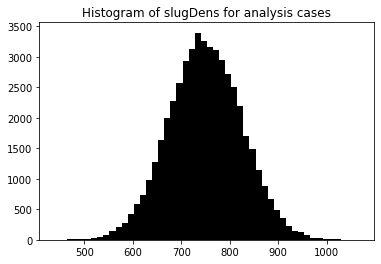

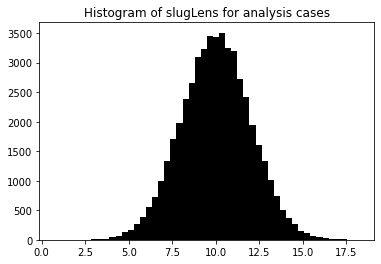

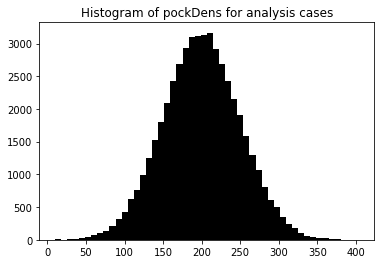

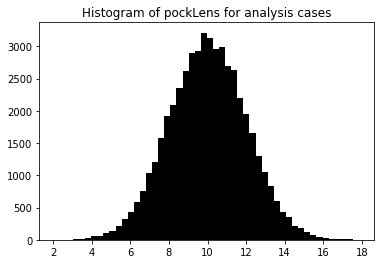

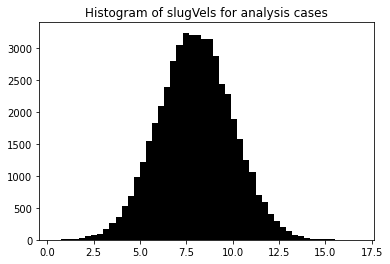

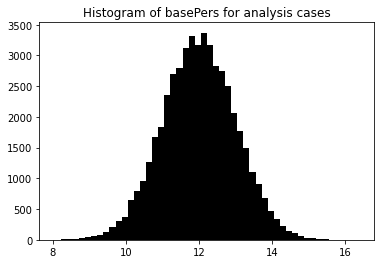

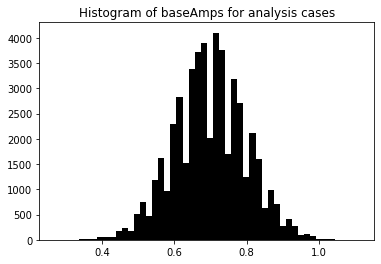

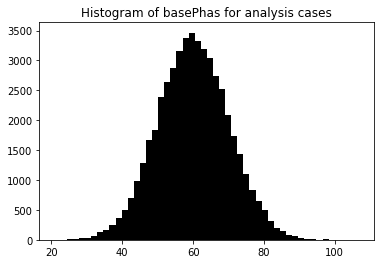

In [17]:
# Plot the load case distributions for each param (as verification)
for ppt in param_lists:
    plt.hist(globals()[ppt], bins = 50, color = 'black')
    plt.title(f'Histogram of {ppt} for analysis cases')
    plt.show()

In [26]:
# Write the load case details as a csv
abt.to_csv('220304_abt.csv', index=False)

In [18]:
# Define slug load case parameters
slugCou = 12 # Number of slugs to pass through the structure
trackNode1 = 57 # Nodes to track motions
trackNode2 = 17

In [22]:
# We need to create the files in buckets so that they can be easily moved to run 
# different buckets on different compute resources.
bs = 1000 # Bucket size (how many files to dump in each folder)
cn = 1 # File counter
bu = 1 # Bucket counter
for r in range(len(abt)):
    dyn_file = [
        '$PREPROCESSOR',
        '*PARAMETERS',
        f' slugLen, {abt.slugLen[r]}',
        f' pockLen, {abt.pockLen[r]}',
        f' slugDen, {abt.slugDen[r]}',
        f' pockDen, {abt.pockDen[r]}',
        f' slugVel, {abt.slugVel[r]}',
        f' slugCou, {slugCou}',
        '',
        '$LOAD CASE',
        '*NAME',
        f' {abt.loadCase[r]}',
        '',
        '*ANALYSIS TYPE',
        ' TYPE=DYNAMIC',
        '',
        '*RESTART',
        ' LAST="static"',
        '',
        '*SLUGS',
        ' PROPERTIES=CONSTANT',
        ' SET=Spool',
        ' =[slugLen], =[slugDen], =[-1*slugVel], 1, =[slugCou], =[slugLen/slugVel + pockLen/SlugVel], COLOUR=Red',
        ' =[pockLen], =[pockDen], =[-1*slugVel], =[1 + slugLen/slugVel], =[slugCou], =[slugLen/slugVel + pockLen/SlugVel], COLOUR=PaleVioletRed',
        '',
        '*BOUNDARY',
        ' TYPE=CONSTANT',
        ' {Line_1_Start}, 1, 0.0, FIXATION=ABSOLUTE',
        ' {Line_1_Start}, 2, 0.0, FIXATION=ABSOLUTE',
        ' {Line_1_Start}, 3, 0.0, FIXATION=ABSOLUTE',
        ' {Line_1_Start}, 4, 0.0, FIXATION=ABSOLUTE',
        ' {Line_1_Start}, 5, 0.0, FIXATION=ABSOLUTE',
        ' {Line_1_Start}, 6, 0.0, FIXATION=ABSOLUTE',
        '',
        ' {Line_9_End}, 1, 0.0, FIXATION=ABSOLUTE',
        ' {Line_9_End}, 3, 0.0, FIXATION=ABSOLUTE',
        ' {Line_9_End}, 4, 0.0, FIXATION=ABSOLUTE',
        ' {Line_9_End}, 5, 0.0, FIXATION=ABSOLUTE',
        ' {Line_9_End}, 6, 0.0, FIXATION=ABSOLUTE',
        '',
        ' TYPE=SINUSOIDAL',
        f' Line_9_End, 2, {abt.baseAmp[r]}, {abt.basePha[r]}, {abt.basePer[r]}',
        '',
        '*TIME',
        ' STEP=FIXED',
        ' =1, =[1 + slugCou*(slugLen/slugVel + pockLen/slugVel) + (60/slugVel)], 0.1',
        '',
        '*DATABASE',
        ' TIME=SELECTED',
        ' =[1 + (60/slugVel)], 0.1',
        '',
        '*DATABASE CONTENT',
        'C 1: Motions, 4: Reactions, 9 & 10: local-x and y bending moment',
        ' INCLUDE=1, 4, 9, 10',
        ' EXCLUDE=2, 3, 5, 6, 7, 8, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20',
        '',
        '*TOLERANCE',
        ' ANALYSIS=STATIC/TIME',
        ' 0.025, 100',
        '',
        '',
        '$DATABASE POSTPROCESSING',
        '*TIMETRACE',
        ' TYPE=KINEMATIC',
        f' {trackNode1}, 1, 1.0, PARA=M, UNITS=m',
        f' TITLE=Node {trackNode1} Global-X (vert)',
        ' TYPE=KINEMATIC',
        f' {trackNode1}, 2, 1, PARA=M, UNITS=m',
        f' TITLE=Node {trackNode1} Global-Y (horiz) motion',
        ' TYPE=KINEMATIC',
        f' {trackNode1}, 3, 1, PARA=M, UNITS=m',
        f' TITLE=Node {trackNode1} Global-Z (horiz) motion',
        ' TYPE=KINEMATIC',
        f' {trackNode2}, 3, 1, PARA=M, UNITS=m',
        f' TITLE=Node {trackNode2} Global-Z (horiz) motion',
        ' TYPE=FORCE',
        ' {Line_9_Last}, 3, 8, , , UNITS=kN.m',
        ' TITLE=Bending Moment at Riser End',
        ' TYPE=CONTACT',
        ' NAME=Support_A, 4, , UNITS=kN',
        ' TITLE=Support A Reaction Force',
        ' TYPE=CONTACT',
        ' NAME=Support_B, 4, , UNITS=kN',
        ' TITLE=Support B Reaction Force'
    ]

    # Write the dynamic keyword file
    filename = f'{fo_p}bucket{bu}/{abt.loadCase[r]}'
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    with open(filename, "w") as f:
        f.write('\n'.join(dyn_file))
    
    # Change the subfolder if we hit the bucket size
    if cn % bs == 0:
        bu += 1
    
    # Increment the file counter
    cn += 1

In [ ]:
abt.loadCase[0]

In [28]:
# Write the static file to each bucket folder
sub_folders = [name for name in os.listdir(fo_p) if os.path.isdir(os.path.join(fo_p, name))]
for sub in sub_folders:
    with open(f'{fo_p}/{sub}/{fn_s}', 'w') as f:
        f.write('\n'.join(key_file))

### Bat File Creation
Create a batch file to process each keyword file in each bucket. Each row of the batch file will call the Flexcom analysis engine (fl3.exe) on each keyword file.

In [25]:
# Bat file name
fn_b = 'run_all.bat'

# Location of Flexcom executable (on machine that the analyses will be run from...)
fl_x = '"C:\Program Files\Wood\Flexcom\Version 8.10.4\\bin\\fl3.exe"'

sub_folders = [name for name in os.listdir(fo_p) if os.path.isdir(os.path.join(fo_p, name))]

# Write the bat file
for sub in sub_folders:
    with open(f'{fo_p}/{sub}/{fn_b}', 'w') as f:
        f.write(f'{fl_x} static.keyxm')
        f.write('\n')
        files_in_bucket = gb.glob(f'{fo_p}/{sub}/*.keyxm')
        files_in_bucket.sort()
        for r in files_in_bucket: 
            # Write each load case name with flexcom location to each row
            f.write(f'{fl_x} {ntpath.basename(r)}')
            f.write('\n')

### Postprocessing Results (Not Used)
See separate processing notebook.

In [ ]:
plot_files = gb.glob('*.mplt')

In [ ]:
print(plot_files)

In [ ]:
for file_p in plot_files:
    plot_raw = pd.read_csv(file_p, skiprows=12, delimiter='"')
    dat_dt = {'time':plot_raw.iloc[:,3].dropna(), 'value':plot_raw.iloc[:,5].dropna()}
    dat_df = pd.DataFrame(dat_dt)
    #print(dat_df)
    dat_range = dat_df.value.max() - dat_df.value.min()
    print(1000*dat_range)

In [ ]:
dat_df.value.max() - dat_df.value.min()